In [1]:
from experiments.mnli_utils import *
from experiments.mnli import main, plot_Xs_and_Ys_dict
from experiments.mnli import *

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
task_tokenizer, task_model = create_tokenizer_and_model(
    "/export/home/Experiments/20200706/")

imitator_tokenizer, imitator_model = create_tokenizer_and_model(
    "/export/home/Experiments/20200718/output_dir/")

train_dataset, eval_dataset = create_datasets(tokenizer=task_tokenizer)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

In [3]:
imitator_model.cuda()
print(task_model.training, imitator_model.training)
print(task_model.device, imitator_model.device)

False False
cpu cuda:0


In [4]:
from transformers import glue_output_modes, TrainingArguments, glue_compute_metrics

output_mode = glue_output_modes["mnli"]
def build_compute_metrics_fn(task_name: str):
    def compute_metrics_fn(p):
        if output_mode == "classification":
            preds = np.argmax(p.predictions, axis=1)
        elif output_mode == "regression":
            preds = np.squeeze(p.predictions)
        return glue_compute_metrics(task_name, preds, p.label_ids)

    return compute_metrics_fn


trainer = Trainer(
    model=task_model,
    args=TrainingArguments(output_dir="./tmp-output", per_device_train_batch_size=128, per_device_eval_batch_size=128, learning_rate=5e-5, logging_steps=100),
    data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=build_compute_metrics_fn("mnli"),
)

train_batch_data_loader = get_dataloader(
    train_dataset,
    batch_size=128,
    data_collator=default_data_collator)

train_instance_data_loader = get_dataloader(
    train_dataset,
    batch_size=1,
    data_collator=default_data_collator)

eval_instance_data_loader = get_dataloader(
    eval_dataset,
    batch_size=1,
    data_collator=default_data_collator)

In [5]:
# outputs_collections = main(
#     label_list=train_dataset.label_list,
#     task_model=task_model,
#     imitator_model=imitator_model,
#     trainer=trainer,
#     batch_train_data_loader=train_batch_data_loader,
#     instance_train_data_loader=train_instance_data_loader,
#     instance_eval_data_loader=eval_instance_data_loader,
#     test_data_point_indices=[3, 14, 15, 24, 25, 29, 31, 32, 38, 41][5:],
#     finetune_using_ground_truth_label=False)

In [6]:
for test_inputs in eval_instance_data_loader:
    break
for k, v in test_inputs.items():
    if isinstance(v, torch.Tensor):
        test_inputs[k] = v.to(trainer.args.device)

In [12]:
# influences, s_test = get_influences(
#     k=10000,
#     model=task_model,
#     test_inputs=test_inputs,
#     batch_train_data_loader=train_batch_data_loader,
#     instance_train_data_loader=train_instance_data_loader)

Loaded FAISS index with 392702 entries


781.86 | 0.32: : 302it [03:08,  1.60it/s]                        
100%|██████████| 392702/392702 [05:33<00:00, 1177.44it/s]


In [16]:
# torch.save(s_test, "/export/home/Experiments/20200725/s_test.trial.pt")

In [119]:
from influence_utils.influence import compute_s_test

def get_s_test(model, n, random, scale, damp, batch_size):
    params_filter = [
        n for n, p in model.named_parameters()
        if not p.requires_grad]

    weight_decay_ignores = [
        "bias",
        "LayerNorm.weight"] + [
        n for n, p in model.named_parameters()
        if not p.requires_grad]
    
    # Make sure each dataloader is re-initialized
    train_batch_data_loader = get_dataloader(
        train_dataset,
        batch_size=batch_size,
        random=random,
        data_collator=default_data_collator)

    s_test = compute_s_test(
        n_gpu=1,
        device=torch.device("cuda"),
        model=model,
        test_inputs=test_inputs,
        train_data_loaders=[train_batch_data_loader],
        params_filter=params_filter,
        weight_decay=0.005,
        weight_decay_ignores=weight_decay_ignores,
        damp=damp,
        scale=scale,
        num_samples=n)
    return [x.cpu() for x in s_test]

In [106]:
s_test_10 = get_s_test(task_model, 500, False, scale=1e9, damp=0.0)

5780.57 | 11.49: : 502it [05:13,  1.60it/s]                       


In [108]:
s_test_10 = get_s_test(task_model, 500, False, scale=1e9, damp=3e-3)

2985.56 | 2.54: : 502it [05:13,  1.60it/s]                       


In [111]:
s_test_10 = get_s_test(task_model, 500, False, scale=1e4, damp=3e-3)

2297.04 | 2.50: : 502it [05:13,  1.60it/s]                       


In [112]:
s_test_10 = get_s_test(task_model, 500, False, scale=1e9, damp=1e-2)

1141.91 | 0.07: : 502it [05:13,  1.60it/s]                       


In [113]:
s_test_10 = get_s_test(task_model, 500, False, scale=1e4, damp=1e-2)

909.31 | 0.43: : 502it [05:13,  1.60it/s]                        


In [114]:
s_test_10 = get_s_test(task_model, 500, False, scale=1e3, damp=1e-2)

814.43 | 1.48: : 502it [05:13,  1.60it/s]                        


In [116]:
s_test_10 = get_s_test(task_model, 500, False, scale=5e2, damp=1e-2)

785.89 | 1.97: : 502it [05:13,  1.60it/s]                        


In [134]:
# batch_size = 8
s_test_n1000_s10000_damp0005_bs128 = get_s_test(task_model, 1000, False, scale=1e4, damp=5e-3, batch_size=128)

1764.77 | 0.09: : 1002it [10:26,  1.60it/s]                         


In [135]:
s_test_n1000_s10000_damp0005_bs8s = []
for i in range(8):
    s_test_n1000_s10000_damp0005_bs8 = get_s_test(
        task_model, 1000, True, scale=1e4, damp=5e-3, batch_size=2)
    s_test_n1000_s10000_damp0005_bs8s.append(s_test_n1000_s10000_damp0005_bs8)

1759.17 | 0.04: : 1002it [00:43, 23.19it/s]                         
1752.54 | -2.49: : 1002it [00:45, 22.13it/s]                        
1774.95 | 0.72: : 1002it [00:46, 21.75it/s]                         
1786.00 | 0.96: : 1002it [00:47, 21.14it/s]                         
1797.45 | 0.97: : 1002it [00:53, 18.59it/s]                         
1756.59 | 1.26: : 1002it [00:41, 24.42it/s]                         
1770.05 | -6.89: : 1002it [00:45, 21.81it/s]                        
1776.72 | 1.71: : 1002it [00:41, 24.40it/s]                         


In [145]:
s_test_n1000_s10000_damp0005_bs128_concat = torch.cat([x.flatten() for x in s_test_n1000_s10000_damp0005_bs128])
s_test_n1000_s10000_damp0005_bs8_concat = [
    torch.cat([x.flatten() for x in z])
    for z in s_test_n1000_s10000_damp0005_bs8s]

0 tensor(5.1845e-05) tensor(5.1845e-05)
1 tensor(3.7352e-05) tensor(5.1169e-05)
2 tensor(2.9541e-05) tensor(4.7000e-05)
3 tensor(2.4624e-05) tensor(5.0938e-05)
4 tensor(2.2320e-05) tensor(4.9171e-05)
5 tensor(1.9976e-05) tensor(4.2579e-05)
6 tensor(1.8349e-05) tensor(4.7223e-05)
7 tensor(1.7582e-05) tensor(5.6914e-05)


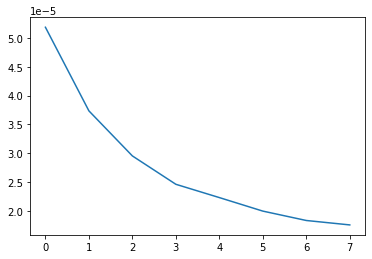

In [147]:
error_norms = []
for i in range(len(s_test_n1000_s10000_damp0005_bs8_concat)):
    A = s_test_n1000_s10000_damp0005_bs128_concat
    B = torch.stack(s_test_n1000_s10000_damp0005_bs8_concat[:i+1], dim=0).mean(dim=0)
    C = s_test_n1000_s10000_damp0005_bs8_concat[i]
    print(i, (A - B).norm(), (A - C).norm())
    error_norms.append((A - B).norm())

plt.plot(error_norms)

In [50]:
# results = {}
# for n in [5000, 1000, 500, 100, 50, 10]:
#     results[n] = get_s_test(task_model, n, False)

811.18 | 0.62:  61%|██████▏   | 3068/5000 [31:56<20:07,  1.60it/s] 
813.35 | -0.34: : 1002it [10:26,  1.60it/s]                        
814.43 | 1.48: : 502it [05:13,  1.60it/s]                        
549.78 | 3.26: : 102it [01:03,  1.60it/s]                       
363.01 | 4.81: : 52it [00:32,  1.60it/s]                      
113.96 | 8.09: : 12it [00:07,  1.60it/s]                     


In [53]:
results.keys()

dict_keys([5000, 1000, 500, 100, 50, 10])

In [51]:
# parallel_s_test_10s = []
# for i in range(4):
#     _s_test_25 = get_s_test(task_model, 25, False)
#     parallel_s_test_10s.append(_s_test_25)

In [30]:
# new_s_test = []
# for j in range(len(parallel_s_test_10s[0])):
#     new_s_test.append(
#         torch.stack([parallel_s_test_10s[i][j] for i in range(len(parallel_s_test_10s))], dim=0).mean(dim=0))

tensor([-1.1038e-07,  2.4554e-08,  1.5781e-08,  ..., -5.0017e-07,
         8.5542e-07, -3.5526e-07])

In [60]:
diffs = {}
for key, val in results.items():
    a = torch.cat([x.flatten() for x in results[key]])
    b = torch.cat([x.flatten() for x in results[5000]])
    diffs[key] = (a - b).norm()

{5000: tensor(0.),
 1000: tensor(0.0015),
 500: tensor(0.0037),
 100: tensor(0.0138),
 50: tensor(0.0182),
 10: tensor(0.0250)}

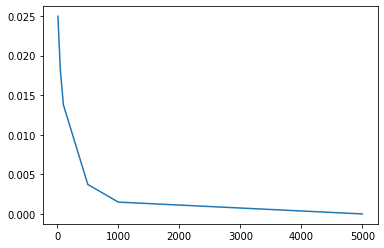

In [69]:
import matplotlib.pyplot as plt
plt.plot(list(diffs.keys()), list(diffs.values()))
diffs

In [20]:
from torch.utils.data.sampler import SequentialSampler, RandomSampler
def get_dataloader(dataset: GlueDataset,
                   batch_size: int,
                   random: bool = False,
                   data_collator: Optional[DataCollator] = None
                   ) -> DataLoader:
    if data_collator is None:
        data_collator = default_data_collator

    if random is True:
        sampler = RandomSampler(dataset)
    else:
        sampler = SequentialSampler(dataset)

    data_loader = DataLoader(
        dataset,
        sampler=sampler,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    return data_loader

In [11]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import transformers
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict
from influence_utils import influence as nn_influence_utils
from influence_utils import faiss_utils
from typing import List, Dict, Tuple, Optional, Union, Any

from experiments.mnli_utils import predict

WEIGHT_DECAY = 0.005
FAISS_INDEX_PATH = "/export/home/Experiments/20200713/MNLI.index"
TRAIN_INPUT_COLLECTIONS_PATH = "/export/home/Experiments/20200706/train_inputs_collections.tmp.pt.full"


def get_influences(
        k: int,
        model: torch.nn.Module,
        test_inputs: Dict[str, torch.Tensor],
        batch_train_data_loader: torch.utils.data.DataLoader,
        instance_train_data_loader: torch.utils.data.DataLoader,
        precomputed_s_test: Optional[List[torch.FloatTensor]] = None,
) -> Tuple[Dict[int, float], List[torch.FloatTensor]]:

    faiss_index = faiss_utils.FAISSIndex(768, "Flat")
    faiss_index.load(FAISS_INDEX_PATH)
    print(f"Loaded FAISS index with {len(faiss_index)} entries")

    test_features = experimental_compute_BERT_CLS_feature(model, **test_inputs)
    test_features = test_features.cpu().detach().numpy()
    KNN_distances, KNN_indices = faiss_index.search(
        k=k, queries=test_features)

    # Make sure indices are sorted according to distances
    # KNN_distances[(
    #     KNN_indices.squeeze(axis=0)[
    #         np.argsort(KNN_distances.squeeze(axis=0))
    #     ] != KNN_indices)]

    params_filter = [
        n for n, p in model.named_parameters()
        if not p.requires_grad]

    weight_decay_ignores = [
        "bias",
        "LayerNorm.weight"] + [
        n for n, p in model.named_parameters()
        if not p.requires_grad]

    (influences,
     train_inputs_collections,
     s_test) = nn_influence_utils.compute_influences(
        n_gpu=1,
        device=torch.device("cuda"),
        model=model,
        test_inputs=test_inputs,
        batch_train_data_loader=batch_train_data_loader,
        instance_train_data_loader=instance_train_data_loader,
        params_filter=params_filter,
        weight_decay=WEIGHT_DECAY,
        weight_decay_ignores=weight_decay_ignores,
        s_test_scale=1000,
        s_test_num_samples=300,
        precomputed_s_test=precomputed_s_test,
        train_indices_to_include=KNN_indices)

    return influences, s_test


class Influence(torch.nn.Module):
    def __init__(self,
                 n_gpu: int,
                 model: torch.nn.Module,
                 params_filter: Optional[List[str]] = None,
                 weight_decay: Optional[float] = None,
                 weight_decay_ignores: Optional[List[str]] = None):

        super(Influence, self).__init__()

        if weight_decay_ignores is None:
            # https://github.com/huggingface/transformers/blob/v3.0.2/src/transformers/trainer.py#L325
            weight_decay_ignores = [
                "bias",
                "LayerNorm.weight"]

        self._n_gpu = n_gpu
        self._model = model
        self._params_filter = params_filter
        self._weight_decay = weight_decay
        self._weight_decay_ignores = weight_decay_ignores

    def forward(self,
                X: Dict[str, torch.Tensor],
                s_test: List[torch.FloatTensor]
                ) -> torch.FloatTensor:

        grad_z = compute_gradients(
            n_gpu=self._n_gpu,
            device=self.device,
            model=self._model,
            inputs=X,
            params_filter=self._params_filter,
            weight_decay=self._weight_decay,
            weight_decay_ignores=self._weight_decay_ignores)

        with torch.no_grad():
            influence = [
                - torch.sum(x * y)
                for x, y in zip(grad_z, s_test)]

        return sum(influence)


In [6]:
train_inputs_collections = torch.load(
    TRAIN_INPUT_COLLECTIONS_PATH)

In [1]:
import torch

In [2]:
s_test_large_collections = torch.load("/export/home/Experiments/20200727/s_test_large_collections.pt")
s_test_small_collections = torch.load("/export/home/Experiments/20200727/s_test_small_collections.pt")

In [3]:
len(s_test_large_collections), len(s_test_small_collections)

(10, 5)

In [4]:
s_test_large_collections.keys()

dict_keys([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

In [5]:
import matplotlib.pyplot as plt
def flatten_and_concat(Xs):
    return torch.cat([X.flatten() for X in Xs], dim=0)


target = flatten_and_concat(s_test_large_collections[1000][0])
def compute_error_norm(Xs):
    return (flatten_and_concat(Xs) - target).norm()
    
def compute_error_norm_2(list_of_Xs):
    list_of_new_Xs = [flatten_and_concat(Xs) for Xs in list_of_Xs]
    return (torch.stack(list_of_new_Xs, dim=0).mean(dim=0) - target).norm()

In [6]:
all_error_norms_1 = [compute_error_norm(s_test_large_collections[k][0]) for k in sorted(s_test_large_collections.keys())]
all_compute_times_1 = [s_test_large_collections[k][1] / 60 for k in sorted(s_test_large_collections.keys())]

Text(0, 0.5, 'Compute time (Minutes)')

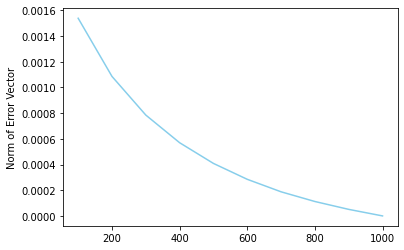

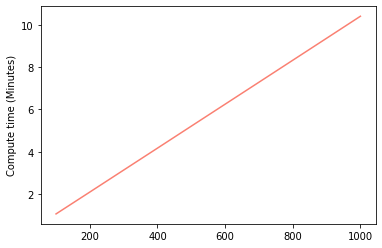

In [7]:
plt.plot(sorted(s_test_large_collections.keys()), all_error_norms_1, color="skyblue")
plt.ylabel("Norm of Error Vector")
plt.figure()
plt.plot(sorted(s_test_large_collections.keys()), all_compute_times_1, color="salmon")
plt.ylabel("Compute time (Minutes)")

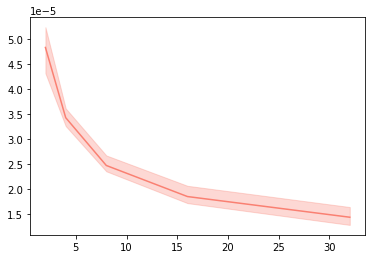

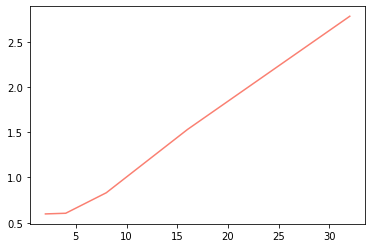

In [8]:
import numpy as np
all_error_norms_2 = []
all_compute_times_2 = []
all_error_norms_2_bounds = []
for k in sorted(s_test_small_collections.keys()):
    compute_time = (s_test_small_collections[k][1] / 8) / 60
    all_compute_times_2.append(compute_time)

    s_tests = s_test_small_collections[k][0]
    error_norms = [compute_error_norm(s_test) for s_test in s_tests]
    all_error_norms_2.append(np.mean(error_norms))
    all_error_norms_2_bounds.append([np.min(error_norms), np.max(error_norms)])

plt.plot(sorted(s_test_small_collections.keys()),
         all_error_norms_2, color="salmon")
plt.fill_between(sorted(s_test_small_collections.keys()),
                 [p[0] for p in all_error_norms_2_bounds],
                 [p[1] for p in all_error_norms_2_bounds],
                 color="salmon", alpha=0.3)
plt.figure()
plt.plot(sorted(s_test_small_collections.keys()),
         all_compute_times_2, color="salmon")

In [9]:
import numpy as np
from collections import defaultdict
all_error_norms_3 = defaultdict(list)
all_compute_times_3 = defaultdict(list)
all_compute_times_3_parallel_limit = defaultdict(list)
for k in sorted(s_test_small_collections.keys()):
    for i in range(8):
        compute_time = (s_test_small_collections[k][1] / 8) / 60
        all_compute_times_3[i + 1].append(compute_time * (i + 1))
        all_compute_times_3_parallel_limit[i + 1].append(compute_time)

        s_tests = s_test_small_collections[k][0]
        error_norms = compute_error_norm_2(s_tests[:i + 1])
        all_error_norms_3[i + 1].append(error_norms)

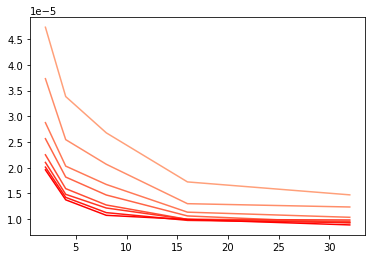

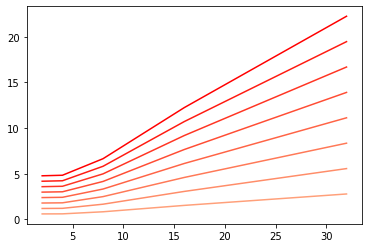

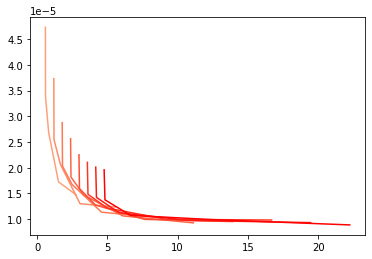

In [10]:
from colour import Color
red = Color("lightsalmon")
colors = list(red.range_to(Color("red"),len(all_error_norms_3)))

for i, k in enumerate(sorted(all_error_norms_3.keys())):
    plt.plot(sorted(s_test_small_collections.keys()), all_error_norms_3[k], color=colors[i].get_hex())
plt.figure()
for i, k in enumerate(sorted(all_error_norms_3.keys())):
    plt.plot(sorted(s_test_small_collections.keys()), all_compute_times_3[k], color=colors[i].get_hex())
plt.figure()
for i, k in enumerate(sorted(all_error_norms_3.keys())):
    plt.plot(all_compute_times_3[k], all_error_norms_3[k], color=colors[i].get_hex())

Text(0, 0.5, 'Norm of Error Vector')

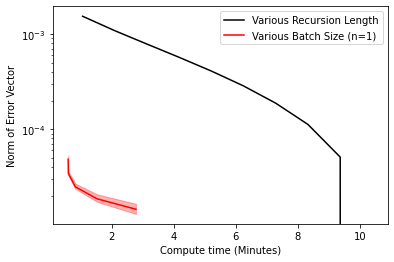

In [11]:
plt.figure()
plt.plot(all_compute_times_1, all_error_norms_1, color="black")
plt.plot(all_compute_times_2, all_error_norms_2, color="red")
plt.fill_between(all_compute_times_2,
                 [p[0] for p in all_error_norms_2_bounds],
                 [p[1] for p in all_error_norms_2_bounds], color="red", alpha=0.3)

plt.yscale("log")
plt.legend(["Various Recursion Length", "Various Batch Size (n=1)"])
plt.xlabel("Compute time (Minutes)")
plt.ylabel("Norm of Error Vector")

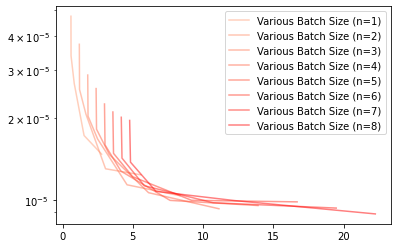

In [12]:
for i, k in enumerate(sorted(all_error_norms_3.keys())):
    plt.plot(all_compute_times_3[k], all_error_norms_3[k], color=colors[i].get_hex(), alpha=0.5)
plt.legend([f"Various Batch Size (n={i})" for i in sorted(all_error_norms_3.keys())])
plt.yscale("log")

In [13]:
target_index_1 = [index for index, err in enumerate(all_error_norms_1) if err < 2e-5][0]
target_index_2 = [index for index, err in enumerate(all_error_norms_2) if err < 2e-5][0]
target_index_3 = [[index for index, err in enumerate(all_error_norms_3[i]) if err < 2e-5][0] for i in range(1, 9)]

In [14]:
target_index_1

9

In [15]:
print("To reach 2e-5 error norm")
print(f"V1: {all_compute_times_1[target_index_1]:.2f} min")
print(f"V2: {all_compute_times_2[target_index_2]:.2f} min")
for i in range(8):
    print(f"V3 (n={i + 1}) {all_compute_times_3[i + 1][target_index_3[i]]:.2f} min, "
          f"or {all_compute_times_3_parallel_limit[i + 1][target_index_3[i]]:.2f} min")

To reach 2e-5 error norm
V1: 10.41 min
V2: 1.53 min
V3 (n=1) 1.53 min, or 1.53 min
V3 (n=2) 3.06 min, or 1.53 min
V3 (n=3) 2.49 min, or 0.83 min
V3 (n=4) 2.42 min, or 0.60 min
V3 (n=5) 3.02 min, or 0.60 min
V3 (n=6) 3.62 min, or 0.60 min
V3 (n=7) 4.23 min, or 0.60 min
V3 (n=8) 4.77 min, or 0.60 min


In [1]:
from experiments.s_test_speedup import *

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
task_tokenizer, task_model = create_tokenizer_and_model(
    "/export/home/Experiments/20200706/")
test_inputs = None
train_dataset, eval_dataset = create_datasets(
    tokenizer=task_tokenizer)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

In [7]:
eval_instance_data_loader = get_dataloader(
    dataset=eval_dataset,
    batch_size=1,
    random=True)